# Modules imports

In [21]:
import os
import matplotlib.pyplot as plt 
import numpy as np
#from skimage.transform import warp

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # ignore TF unsupported NUMA warnings


# Filter out TFA warning
#import warnings
#warnings.filterwarnings("ignore", message="TFA has entered a minimal maintenance and release mode", category=Warning)


import tensorflow as tf
import tensorflow_addons as tfa


# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
   tf.config.experimental.set_memory_growth(gpu, True)


# Hyperparameters

In [2]:
BATCH_SIZE = 3

# Importing dataset

In [3]:
print("Started dataset loading...")

input_path = "/mnt/c/Users/jacop/Desktop/DL_Project/processed_dataset/" #if in wsl
#input_path = "/mnt/c/Users/vitto/Desktop/DL project/DL project github/processed_dataset/" #if in wsl
#input_path = r"C:\Users\vitto\Desktop\DL project\DL project github\processed_dataset"  # if in windows
#input_path = r"C:\Users\jacop\Desktop\DL_Project\processed_dataset"  # if in windows



# Function to process images
def process_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img)
    
    # Check the number of channels in the image
    num_channels = tf.shape(img)[-1]

    if num_channels > 1:
        # Convert the image to grayscale if it has multiple channels
        img = tf.image.rgb_to_grayscale(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img / 255.0
    return img

# Function to process labels
def load_labels(label_path):
    label_path_str = label_path.numpy().decode('utf-8')
    landmarks = []

    with open(label_path_str, 'r') as file:
        next(file)  # Skip the first line

        for line in file:
            columns = line.strip().split("\t")
            x_value = float(columns[1]) / 256.0
            y_value = float(columns[2]) / 256.0
            landmarks.extend([x_value, y_value])

    return tf.convert_to_tensor(landmarks, dtype=tf.float32)

# Define the file patterns for images and labels
train_image_path = os.path.join(input_path, "images/train", "*.jpg")
test_image_path = os.path.join(input_path, "images/test", "*.jpg")
val_image_path = os.path.join(input_path, "images/val", "*.jpg")

train_label_pattern = os.path.join(input_path, "labels/train", "*.txt")
test_label_pattern = os.path.join(input_path, "labels/test", "*.txt")
val_label_pattern = os.path.join(input_path, "labels/val", "*.txt")

# Create datasets for images and labels
train_images = tf.data.Dataset.list_files(train_image_path, shuffle=False)
test_images = tf.data.Dataset.list_files(test_image_path, shuffle=False)
val_images = tf.data.Dataset.list_files(val_image_path, shuffle=False)

train_labels = tf.data.Dataset.list_files(train_label_pattern, shuffle=False)
test_labels = tf.data.Dataset.list_files(test_label_pattern, shuffle=False)
val_labels = tf.data.Dataset.list_files(val_label_pattern, shuffle=False)

# Process images and load labels
train_images = train_images.map(process_image)
test_images = test_images.map(process_image)
val_images = val_images.map(process_image)

train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], tf.float32))
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], tf.float32))
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], tf.float32))


# Combine images and labels
train_dataset = tf.data.Dataset.zip((train_images, train_labels))
test_dataset = tf.data.Dataset.zip((test_images, test_labels))
val_dataset = tf.data.Dataset.zip((val_images, val_labels))


Started dataset loading...


# U-Net

Creating generators

In [4]:
print("Started U-Net training...")
 
# We only need images in this part
train_images_only = train_dataset.map(lambda img, lbl: img)
test_images_only = test_dataset.map(lambda img, lbl: img)
val_images_only = val_dataset.map(lambda img, lbl: img)


train_list = list(train_images_only)
val_list = list(val_images_only)

fixed_image = train_list[2]

# Create a generator function to yield the combined image tensor
def train_image_generator():
    for moving_image in train_list[1:]:
        # Combine fixed and moving images into a single tensor
        combined_image = tf.concat([fixed_image, moving_image], axis=2)  # Stack along the third axis
        yield (combined_image, fixed_image)


# Create a TensorFlow dataset from the generator
train_images_dataset = tf.data.Dataset.from_generator(
    train_image_generator,
    output_signature=(tf.TensorSpec(shape=(256, 256, 2), dtype=tf.float32),
                      tf.TensorSpec(shape=(256, 256, 1), dtype=tf.float32))
    )
train_images_dataset = train_images_dataset.shuffle(1000).batch(BATCH_SIZE)

val_list = list(val_images_only)



# Create a generator function to yield the combined image tensor for validation
def val_image_generator():
    for moving_image in val_list:
        combined_image = tf.concat([fixed_image, moving_image], axis=2)  # Stack along the third axis
        yield (combined_image, fixed_image)

# Create a TensorFlow dataset from the generator for validation
val_images_dataset = tf.data.Dataset.from_generator(
    val_image_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256,1), dtype=tf.float32)
    )
)

# No need to shuffle for the validation set
val_images_dataset = val_images_dataset.batch(BATCH_SIZE)

Started U-Net training...


U-net architecture

In [23]:
input_shape = (256, 256, 2)


# Due immagini, una fixed e una moving, prese come input
input = tf.keras.layers.Input(shape=input_shape)

### Downsampling path ###

# Applicazione della funzione di attivazione Leaky ReLU con coefficiente alpha
a1 = tf.keras.layers.LeakyReLU(alpha=0.01)(input)

# Applicazione di un layer di convoluzione 2D con 64 filtri di dimensione 3x3
c1 = tf.keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_normal")(a1)

# Applicazione del layer di Dropout con un tasso di dropout del 10%
c1 = tf.keras.layers.Dropout(0.1)(c1)

# Applicazione del max-pooling con una finestra di pooling di dimensione 2x2
p1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)


a2 = tf.keras.layers.LeakyReLU(alpha=0.01)(p1)
c2 = tf.keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_normal")(a2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c2)

a3 = tf.keras.layers.LeakyReLU(alpha=0.01)(p2)
c3 = tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer="he_normal")(a3)
c3 = tf.keras.layers.Dropout(0.2)(c3)
p3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c3)

a4 = tf.keras.layers.LeakyReLU(alpha=0.01)(p3)
c4 = tf.keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_normal")(a4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

a5 = tf.keras.layers.LeakyReLU(alpha=0.01)(p4)
c5 = tf.keras.layers.Conv2D(1024, 3, padding="same", kernel_initializer="he_normal")(a5)
c5 = tf.keras.layers.Dropout(0.3)(c5)

### Upsampling path ###

# Decodifica dell'output dell'encoder con la trasposizione della convoluzione 2D
u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5)
u6 = tf.keras.layers.concatenate(
    [u6, c4]
)  # Concatenazione dell'output con gli strati dell'encoder precedenti
a6 = tf.keras.layers.LeakyReLU(alpha=0.01)(u6)  # Applicazione di Leaky ReLU
c6 = tf.keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_normal")(
    a6
)  # Convoluzione 2D
c6 = tf.keras.layers.Dropout(0.3)(c6)  # Applicazione di Dropout

u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
a7 = tf.keras.layers.LeakyReLU(alpha=0.01)(u7)
c7 = tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer="he_normal")(a7)
c7 = tf.keras.layers.Dropout(0.2)(c7)

u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
a8 = tf.keras.layers.LeakyReLU(alpha=0.01)(u8)
c8 = tf.keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_normal")(a8)
c8 = tf.keras.layers.Dropout(0.2)(c8)

u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
a9 = tf.keras.layers.LeakyReLU(alpha=0.01)(u9)
c9 = tf.keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_normal")(a9)
c9 = tf.keras.layers.Dropout(0.1)(c9)

# Creazione dell'output finale del modello
c10 = tf.keras.layers.Conv2D(2, 1, padding="same", kernel_initializer="he_normal")(c9)

# Creazione di un tensore di deformazione
displacement_tensor = tf.keras.layers.Conv2D(
    2, kernel_size=3,activation='linear', padding="same", name="disp"
)(c10)

# Define the function to extract the "bottom" tensor
def extract_moving_img(input):
    return input[:, :, :, 1:2]

moving_image = tf.keras.layers.Lambda(extract_moving_img)(input)

# Creazione di una funzione per applicare la trasformazione di deformazione all'immagine di input
def apply_deformation(inputs):
    #unpacking dell'input
    image, displacement_tensor = inputs
    # Applica la trasformazione di deformazione all'immagine di input utilizzando il tensore di deformazione
    deformed_image = tfa.image.dense_image_warp(image, displacement_tensor)
    return deformed_image
def_image = tf.keras.layers.Lambda(apply_deformation)([moving_image,displacement_tensor])

output = def_image

ValueError: Exception encountered when calling layer "lambda_6" (type Lambda).

Dimension must be 4 but is 3 for '{{node lambda_6/transpose}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32](Placeholder_1, lambda_6/transpose/perm)' with input shapes: [?,256,256,2], [3].

Call arguments received by layer "lambda_6" (type Lambda):
  • inputs=['tf.Tensor(shape=(None, 256, 256, 1), dtype=float32)', 'tf.Tensor(shape=(None, 256, 256, 2), dtype=float32)']
  • mask=None
  • training=None

Model Initialization

In [19]:
# Create the U-Net model
unet = tf.keras.Model(inputs=input, outputs=output)

def custom_mse_loss(y_true, y_pred):
    # Calcola l'errore quadratico medio tra i tensori y_true e y_pred
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse


# Compile the model with the custom loss and metric
unet.compile(optimizer='adam', loss=custom_mse_loss, metrics='mse')


Model Training

In [20]:

# Train the model
history = unet.fit(train_images_dataset, epochs=5, validation_data=val_images_dataset)

# Plot training & validation accuracy values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/10


258/258 [==============================] - 46s 163ms/step - loss: 1.7042e-06 - mse: 1.7042e-06 - val_loss: 1.7452e-06 - val_mse: 1.7452e-06
Epoch 2/10
258/258 [==============================] - 42s 161ms/step - loss: 1.7001e-06 - mse: 1.7001e-06 - val_loss: 1.7420e-06 - val_mse: 1.7420e-06
Epoch 3/10
258/258 [==============================] - 42s 162ms/step - loss: 1.6980e-06 - mse: 1.6980e-06 - val_loss: 1.7408e-06 - val_mse: 1.7408e-06
Epoch 4/10
258/258 [==============================] - 42s 162ms/step - loss: 1.6972e-06 - mse: 1.6972e-06 - val_loss: 1.7404e-06 - val_mse: 1.7404e-06
Epoch 5/10
258/258 [==============================] - 44s 165ms/step - loss: 1.6969e-06 - mse: 1.6969e-06 - val_loss: 1.7403e-06 - val_mse: 1.7403e-06
Epoch 6/10
245/258 [===========================>..] - ETA: 1s - loss: 1.6912e-06 - mse: 1.6912e-06

KeyboardInterrupt: 

# Testing the model


1/1 [==============================] - 0s 209ms/step


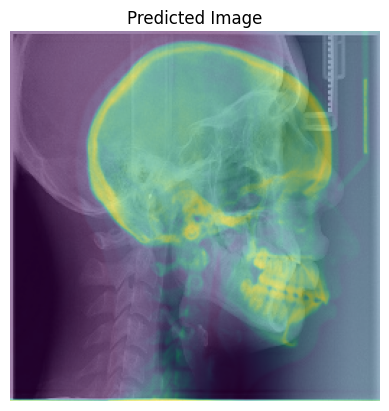

In [ ]:
test_image = test_images_only.as_numpy_iterator().next()

test_feed = tf.concat([fixed_image, test_image], axis=2)
test_feed = tf.expand_dims(test_feed, axis=0)

results = unet.predict(test_feed)
predicted_image = results[0, :, :, 0]  # Extract the 2D image from the batch

plt.imshow(fixed_image, cmap='gray')
plt.imshow(predicted_image, alpha = 0.5)  # Assuming it's a grayscale image
plt.title('Predicted Image')
plt.axis('off')  # Optional, to hide the axis
plt.show()